**Fibonacci Pattern:** 

bullish pattern signal:  
current_close time +8  
close_8d < close_5d   
close_8d < close_3d  
close_8d < close_2d  

bearish pattern:  
current_close time +8  
close_8d > close_5d   
close_8d > close_3d  
close_8d > close_2d  


bullish 无效当 next close <= busilish pattern signal  
bearish 无效当 next close >= bearish pattern signal  


Bollinger Bands:  
buy signal: stock < lower bander  
sell signal: stock > upper bander  

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil
from dateutil.relativedelta import relativedelta
from scipy import stats
import talib

## Simple

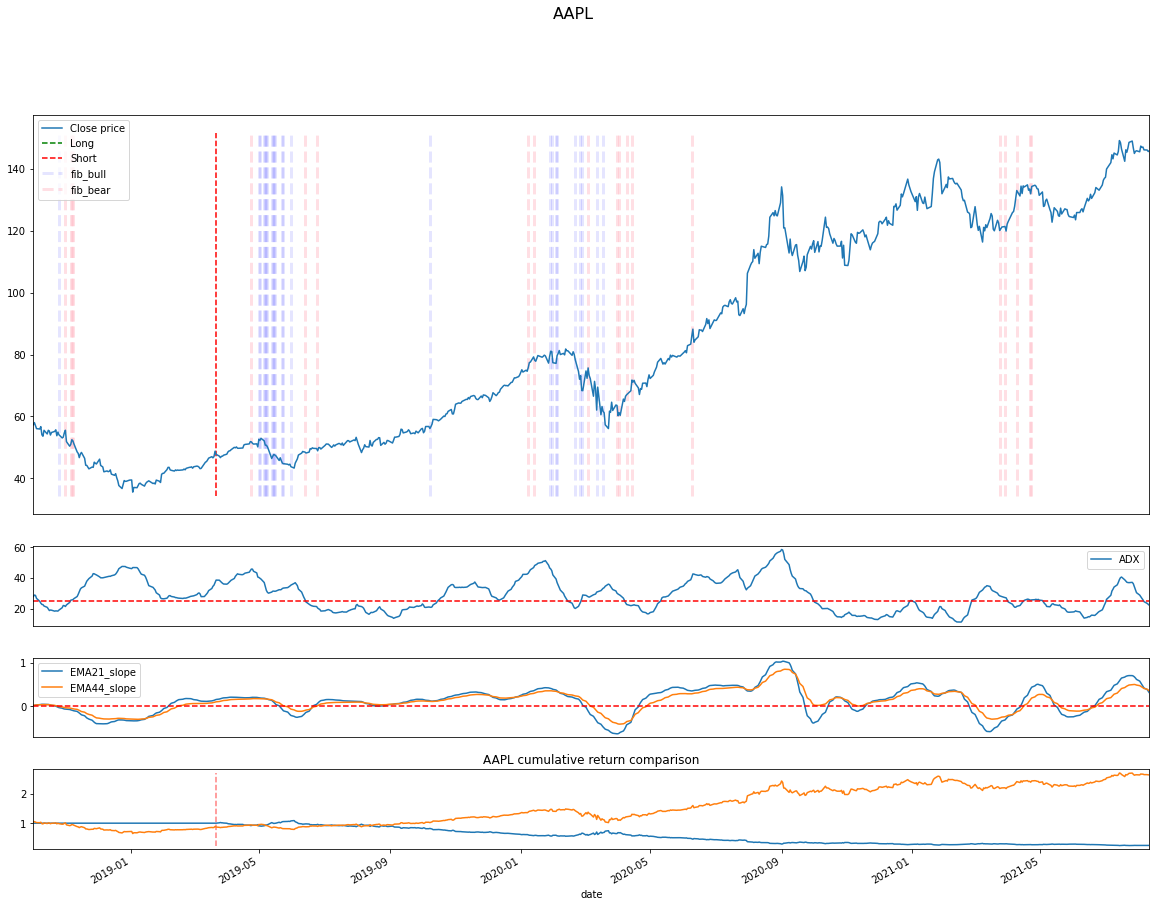

In [134]:
ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

today = datetime.today().strftime('%Y-%m-%d')
delta = dateutil.relativedelta.relativedelta(months = 36)
begin = (datetime.today() - delta).strftime('%Y-%m-%d')

stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
{ticker}?from={begin}&to={today}&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock = stock.sort_values('date').reset_index(drop = True)
stock['date'] = pd.to_datetime(stock['date'])

def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

def EMA(close, n):
    ema = close.ewm(span = n).mean()
    return ema

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
stock['EMA21_slope'] = stock['EMA21'].rolling(21).apply(calc_slope)
stock['EMA44_slope'] = stock['EMA44'].rolling(21).apply(calc_slope)
stock['ADX'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)

stock = stock.dropna()
stock.reset_index(drop = True, inplace = True)

# stock['sig'] = np.nan # bullish or bearish signal
stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
long = [] # long
short = [] # short

for d in range(6,len(stock)-1):
    if (abs(stock.loc[d,'EMA21_slope']) > 0.1) & (stock.loc[d,'ADX'] > 25):
        # bullish signal
        if (stock.loc[d,'close'] < stock.loc[d-3,'close'] < stock.loc[d-5,'close'] < stock.loc[d-6,'close'])\
        & (stock.loc[d+1,'close'] > stock.loc[d,'close']): # compare with next day close price to confirm signal
            if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                if ts != 1:
                    long.append(stock.loc[d+1,'date'])
                    ts = 1
        # bearish signal
        elif (stock.loc[d,'close'] > stock.loc[d-3,'close'] > stock.loc[d-5,'close'] > stock.loc[d-6,'close'])\
        & (stock.loc[d+1,'close'] < stock.loc[d,'close']): # compare with next day close price to confirm signal
            if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                if ts != -1:
                    short.append(stock.loc[d+1,'date'])
                    ts = -1

    stock.loc[d+1,'pos'] = ts

stock = stock.set_index('date')

stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()

# stock['rtn'] = np.log(stock.close.div(stock.close.shift(1)))
# stock['srtn'] = stock.pos.shift(1) * stock.rtn
# stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
# stock['crtn_s'] = stock['srtn'].cumsum().apply(np.exp) # with strategy
# stock = stock.dropna()

# print(short)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# print(stock['close'])

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.xmargin'] = 0
fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 2, 2, 2]})

stock['close'].plot(label = 'Close price', ax = axs[0])
# stock['EMA21'].plot(label = 'EMA_21days', ax = axs[0])
# stock['EMA44'].plot(label = 'EMA_44days', ax = axs[0])
# stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), min(stock.EMA21))
axs[0].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 1)
axs[0].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 1)
axs[0].vlines(fib_bull, ymin = ymin, ymax = ymax,\
              color = 'blue', linestyle = '--', label = 'fib_bull', alpha = 0.1, lw = 3)
axs[0].vlines(fib_bear, ymin = ymin, ymax = ymax,\
              color = 'pink', linestyle = '--', label = 'fib_bear', alpha = 0.5, lw = 3)

stock['ADX'].plot(label = 'ADX', ax = axs[1])
axs[1].axhline(25, color = 'red', linestyle = '--')

stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
axs[2].axhline(0, color = 'red', linestyle = '--')

stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])
ymin = min(min(stock.cum_rtn_s), min(stock.cum_rtn))
ymax = max(max(stock.cum_rtn_s), max(stock.cum_rtn))
axs[3].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
axs[3].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)

axs[0].set(xlabel = '')
axs[1].set(xlabel = '')
axs[2].set(xlabel = '')
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].set_title(f'{ticker} cumulative return comparison')
fig.suptitle(f'{ticker}', fontsize=16)
plt.show()

## Modified

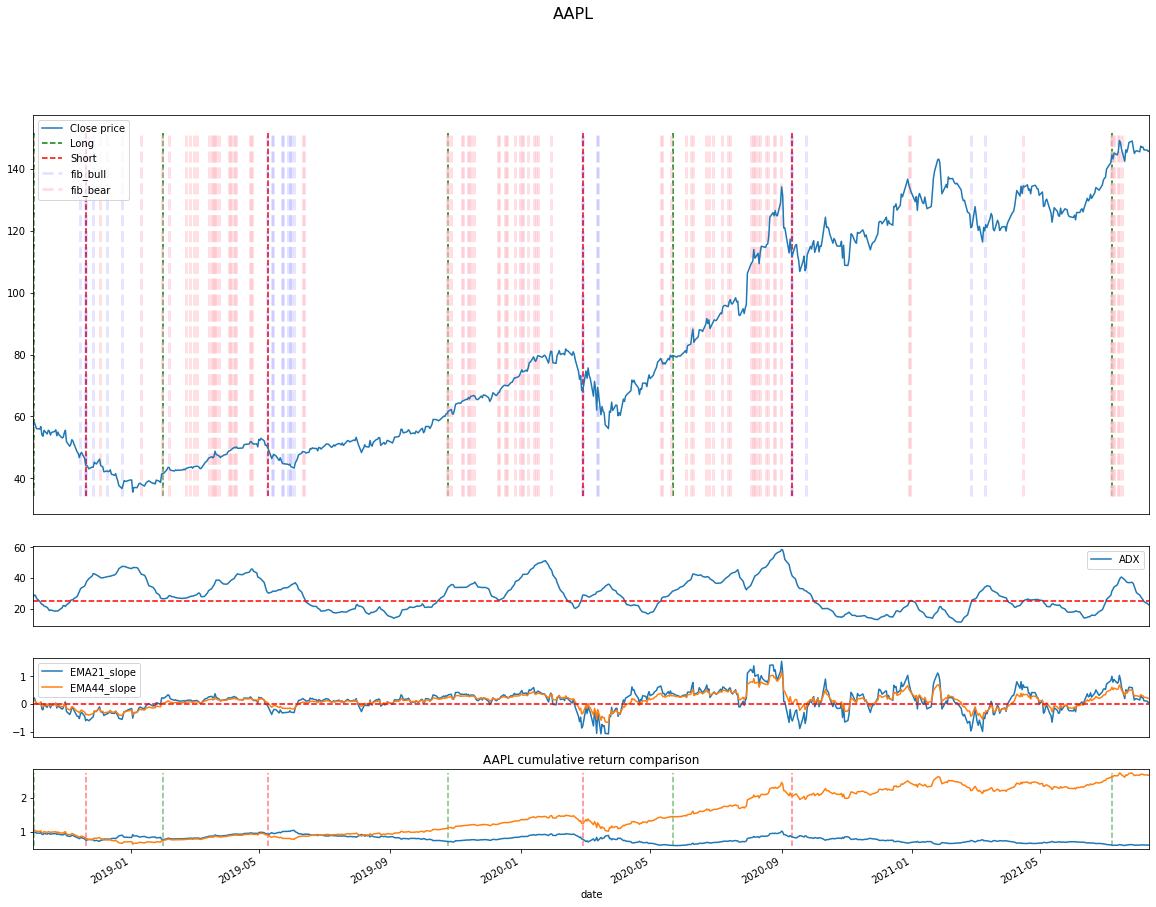

In [135]:
ticker = 'AAPL'
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

today = datetime.today().strftime('%Y-%m-%d')
delta = dateutil.relativedelta.relativedelta(months = 36)
begin = (datetime.today() - delta).strftime('%Y-%m-%d')

stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
{ticker}?from={begin}&to={today}&apikey={fm_key}').json()
stock = pd.DataFrame(stock['historical'])
stock = stock.sort_values('date').reset_index(drop = True)
stock['date'] = pd.to_datetime(stock['date'])

def MA(tp, n):
    ma = tp.rolling(window = n).mean()
    return ma

def EMA(close, n):
    ema = close.ewm(span = n).mean()
    return ema

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def Bounds(tp, sma, n, m):
    std = tp.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
stock['EMA21_slope'] = stock['EMA21'].rolling(2).apply(calc_slope)
stock['EMA44_slope'] = stock['EMA44'].rolling(2).apply(calc_slope)
stock['ADX'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)

stock = stock.dropna()
stock.reset_index(drop = True, inplace = True)

# stock['sig'] = np.nan # bullish or bearish signal
stock['pos'] = np.nan # position for next day
ts = 0 # trading signal
long = [] # long
short = [] # short
fib_bull = []
fib_bear = []
for d in range(6,len(stock)-1):
    if (abs(stock.loc[d+1,'EMA21_slope']) > 0.1) & (stock.loc[d+1,'ADX'] > 25):
        # bullish signal
        if (stock.loc[d,'close'] < stock.loc[d-3,'close'] < stock.loc[d-5,'close'] < stock.loc[d-6,'close']):
            fib_bull.append(stock.loc[d,'date'])
            if (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                    if ts != 1:
                        long.append(stock.loc[d+1,'date'])
                        ts = 1
            elif (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0): # bearish
                #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                    if ts != -1:
                        short.append(stock.loc[d+1,'date'])
                        ts = -1

        # bearish signal
        elif (stock.loc[d,'close'] > stock.loc[d-3,'close'] > stock.loc[d-5,'close'] > stock.loc[d-6,'close']):
            fib_bear.append(stock.loc[d,'date'])
            if (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0):
                #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                    if ts != -1:
                        short.append(stock.loc[d+1,'date'])
                        ts = -1
            elif (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                    if ts != 1:
                        long.append(stock.loc[d+1,'date'])
                        ts = 1

    stock.loc[d+1,'pos'] = ts

stock = stock.set_index('date')

stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

stock['rtn'] = stock['close'].pct_change()
stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

stock = stock.dropna()

# stock['rtn'] = np.log(stock.close.div(stock.close.shift(1)))
# stock['srtn'] = stock.pos.shift(1) * stock.rtn
# stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
# stock['crtn_s'] = stock['srtn'].cumsum().apply(np.exp) # with strategy
# stock = stock.dropna()

# print(short)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# print(stock['close'])

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.xmargin'] = 0
fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 2, 2, 2]})

stock['close'].plot(label = 'Close price', ax = axs[0])
# stock['EMA21'].plot(label = 'EMA_21days', ax = axs[0])
# stock['EMA44'].plot(label = 'EMA_44days', ax = axs[0])
# stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
# stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), min(stock.EMA21))
axs[0].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 1)
axs[0].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 1)
axs[0].vlines(fib_bull, ymin = ymin, ymax = ymax,\
              color = 'blue', linestyle = '--', label = 'fib_bull', alpha = 0.1, lw = 3)
axs[0].vlines(fib_bear, ymin = ymin, ymax = ymax,\
              color = 'pink', linestyle = '--', label = 'fib_bear', alpha = 0.5, lw = 3)

stock['ADX'].plot(label = 'ADX', ax = axs[1])
axs[1].axhline(25, color = 'red', linestyle = '--')

stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
axs[2].axhline(0, color = 'red', linestyle = '--')

stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])
ymin = min(min(stock.cum_rtn_s), min(stock.cum_rtn))
ymax = max(max(stock.cum_rtn_s), max(stock.cum_rtn))
axs[3].vlines(long, ymin = ymin, ymax = ymax,\
              color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
axs[3].vlines(short, ymin = ymin, ymax = ymax,\
              color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)

axs[0].set(xlabel = '')
axs[1].set(xlabel = '')
axs[2].set(xlabel = '')
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].set_title(f'{ticker} cumulative return comparison')
fig.suptitle(f'{ticker}', fontsize=16)
plt.show()

# fig, ax = plt.subplots(figsize = (20, 10))
# stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = ax)
# stock['cum_rtn'].plot(label = 'cum_rtn', ax = ax)
# ymin = min(min(stock.cum_rtn_s), min(stock.cum_rtn))
# ymax = max(max(stock.cum_rtn_s), max(stock.cum_rtn))
# ax.vlines(long, ymin = ymin, ymax = ymax,\
#               color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
# ax.vlines(short, ymin = ymin, ymax = ymax,\
#               color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)
# # ax.vlines(exit, ymin = ymin, ymax = ymax,\
# #               color = 'blue', linestyle = '--', label = 'Exit', alpha = 0.5)
# plt.legend()
# plt.title(f'{ticker} cumulative return comparison')
# plt.show()

# TEST

In [132]:
def fibo_bollin(ticker, start, end):
    import requests
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime
    import dateutil
    from dateutil.relativedelta import relativedelta
    from scipy import stats
    import talib

    fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'
    fh_key = 'bt3efpf48v6tfcs816eg'

    today = datetime.today().strftime('%Y-%m-%d')
    delta = dateutil.relativedelta.relativedelta(months = 36)
    begin = (datetime.today() - delta).strftime('%Y-%m-%d')

    stock = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/\
    {ticker}?from={begin}&to={today}&apikey={fm_key}').json()
    stock = pd.DataFrame(stock['historical'])
    stock = stock.sort_values('date').reset_index(drop = True)
    stock['date'] = pd.to_datetime(stock['date'])

    def MA(tp, n):
        ma = tp.rolling(window = n).mean()
        return ma

    def EMA(close, n):
        ema = close.ewm(span = n).mean()
        return ema

    def calc_slope(x):
        slope = np.polyfit(range(len(x)), x, 1)[0]
        return slope

    def Bounds(tp, sma, n, m):
        std = tp.rolling(window = n).std()
        BOLU = sma + std * m
        BOLD = sma - std * m
        return BOLU, BOLD

    stock['TP'] = stock.loc[:,['high', 'low', 'close']].mean(axis = 1) #typical price
    stock['MA'] = MA(stock['TP'], 5) # 5-days moving average
    stock['BOLU'], stock['BOLD'] = Bounds(stock['TP'], stock['MA'], 5, 2) # lower & upper bands
    stock['EMA21'] = EMA(stock['close'], 21) # 21-days exponential moving average
    stock['EMA44'] = EMA(stock['close'], 44) # 21-days exponential moving average
    stock['EMA21_slope'] = stock['EMA21'].rolling(2).apply(calc_slope)
    stock['EMA44_slope'] = stock['EMA44'].rolling(2).apply(calc_slope)
    stock['ADX'] = talib.ADX(stock.high, stock.low, stock.close, timeperiod = 14)

    stock = stock.dropna()
    stock.reset_index(drop = True, inplace = True)

    # stock['sig'] = np.nan # bullish or bearish signal
    stock['pos'] = np.nan # position for next day
    ts = 0 # trading signal
    long = [] # long
    short = [] # short

    fib_bull = []
    fib_bear = []
    for d in range(6,len(stock)-1):
        if (abs(stock.loc[d+1,'EMA21_slope']) > 0.1) & (stock.loc[d+1,'ADX'] > 25):
            # bullish signal
            if (stock.loc[d,'close'] < stock.loc[d-3,'close'] < stock.loc[d-5,'close'] < stock.loc[d-6,'close']):
                fib_bull.append(stock.loc[d,'date'])
                if (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                    #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                        if ts != 1:
                            long.append(stock.loc[d+1,'date'])
                            ts = 1
                elif (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0): # bearish
                    #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                        if ts != -1:
                            short.append(stock.loc[d+1,'date'])
                            ts = -1

            # bearish signal
            elif (stock.loc[d,'close'] > stock.loc[d-3,'close'] > stock.loc[d-5,'close'] > stock.loc[d-6,'close']):
                fib_bear.append(stock.loc[d,'date'])
                if (stock.loc[d+1,'close'] < stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] < 0):
                    #if stock.loc[d+1,'high'] > stock.loc[d+1,'BOLU']: # overbought
                        if ts != -1:
                            short.append(stock.loc[d+1,'date'])
                            ts = -1
                elif (stock.loc[d+1,'close'] > stock.loc[d,'close']) & (stock.loc[d+1, 'EMA21_slope'] > 0):
                    #if stock.loc[d+1,'low'] < stock.loc[d+1,'BOLD']: # oversold
                        if ts != 1:
                            long.append(stock.loc[d+1,'date'])
                            ts = 1

        stock.loc[d+1,'pos'] = ts

    stock = stock.set_index('date')

    stock['rtn_s'] = stock['close'].pct_change() * stock['pos'].shift(1)
    stock['cum_rtn_s'] = (1 + stock['rtn_s']).cumprod()

    stock['rtn'] = stock['close'].pct_change()
    stock['cum_rtn'] = (1 + stock['rtn']).cumprod()

    stock = stock.dropna()

    # stock['rtn'] = np.log(stock.close.div(stock.close.shift(1)))
    # stock['srtn'] = stock.pos.shift(1) * stock.rtn
    # stock['crtn'] = stock['rtn'].cumsum().apply(np.exp) # without strategy
    # stock['crtn_s'] = stock['srtn'].cumsum().apply(np.exp) # with strategy
    # stock = stock.dropna()

    # print(short)
    # pd.set_option("display.max_rows", None, "display.max_columns", None)
    # print(stock['close'])

    plt.rcParams['figure.figsize'] = (20, 15)
    plt.rcParams['axes.xmargin'] = 0
    fig, axs = plt.subplots(4, 1, gridspec_kw = {'height_ratios': [10, 2, 2, 2]})

    stock['close'].plot(label = 'Close price', ax = axs[0])
    # stock['EMA21'].plot(label = 'EMA_21days', ax = axs[0])
    # stock['EMA44'].plot(label = 'EMA_44days', ax = axs[0])
    # stock['BOLU'].plot(label = 'bollinger upper band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])
    # stock['BOLD'].plot(label = 'bollinger lower band', linestyle = (0, (3, 1, 1, 1)), ax = axs[0])

    ymin = min(min(stock.close), min(stock.BOLU), min(stock.BOLD), min(stock.EMA21))
    ymax = max(max(stock.close), max(stock.BOLU), max(stock.BOLD), min(stock.EMA21))
    axs[0].vlines(long, ymin = ymin, ymax = ymax,\
                  color = 'green', linestyle = '--', label = 'Long', alpha = 1)
    axs[0].vlines(short, ymin = ymin, ymax = ymax,\
                  color = 'red', linestyle = '--', label = 'Short', alpha = 1)
    axs[0].vlines(fib_bull, ymin = ymin, ymax = ymax,\
                  color = 'blue', linestyle = '--', label = 'fib_bull', alpha = 0.1, lw = 3)
    axs[0].vlines(fib_bear, ymin = ymin, ymax = ymax,\
                  color = 'pink', linestyle = '--', label = 'fib_bear', alpha = 0.5, lw = 3)

    stock['ADX'].plot(label = 'ADX', ax = axs[1])
    axs[1].axhline(25, color = 'red', linestyle = '--')

    stock['EMA21_slope'].plot(label = 'EMA21_slope', ax = axs[2])
    stock['EMA44_slope'].plot(label = 'EMA44_slope', ax = axs[2])
    axs[2].axhline(0, color = 'red', linestyle = '--')

    stock['cum_rtn_s'].plot(label = 'cum_rtn with strategy', ax = axs[3])
    stock['cum_rtn'].plot(label = 'cum_rtn', ax = axs[3])
    ymin = min(min(stock.cum_rtn_s), min(stock.cum_rtn))
    ymax = max(max(stock.cum_rtn_s), max(stock.cum_rtn))
    axs[3].vlines(long, ymin = ymin, ymax = ymax,\
                  color = 'green', linestyle = '--', label = 'Long', alpha = 0.5)
    axs[3].vlines(short, ymin = ymin, ymax = ymax,\
                  color = 'red', linestyle = '--', label = 'Short', alpha = 0.5)

    
    axs[0].set(xlabel = '')
    axs[1].set(xlabel = '')
    axs[2].set(xlabel = '')
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].set_title(f'{ticker} cumulative return comparison')
    fig.suptitle(f'{ticker}', fontsize=16)
    plt.show()

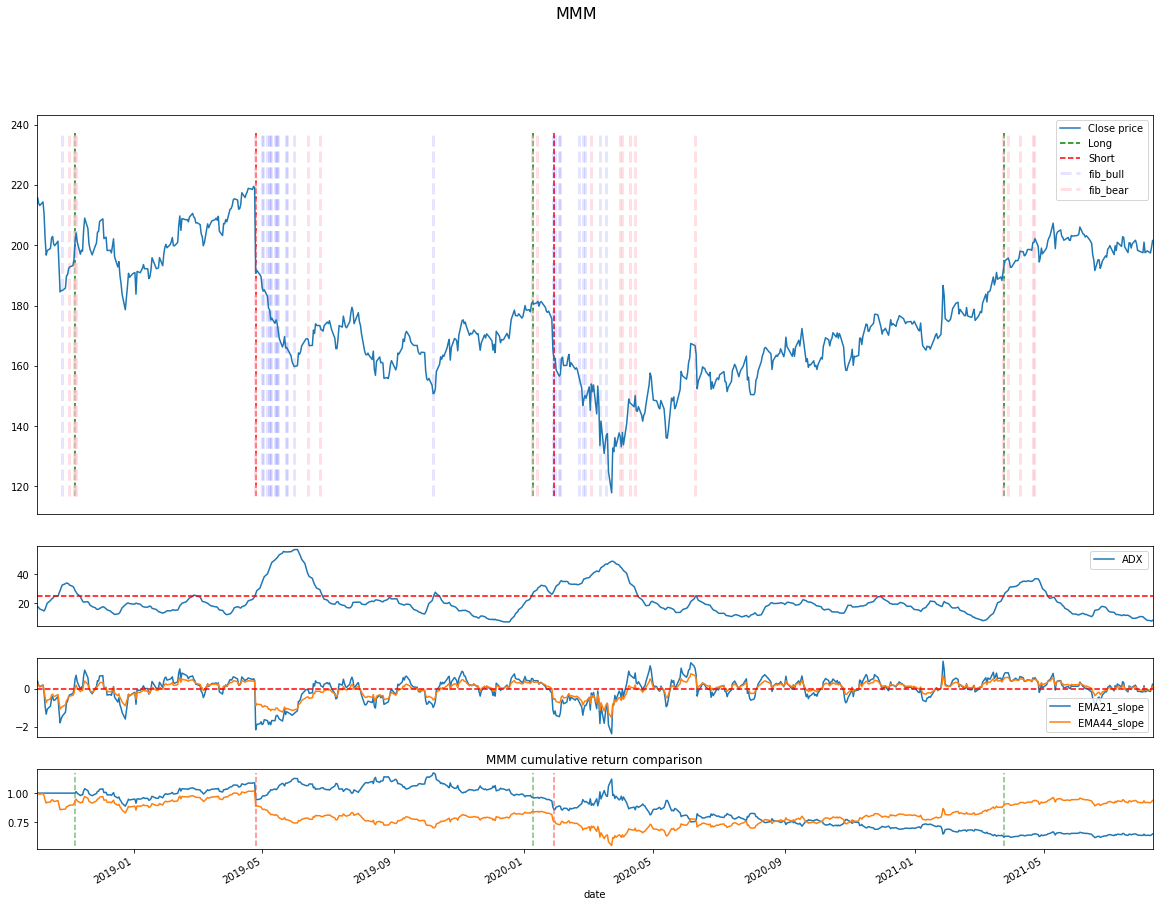

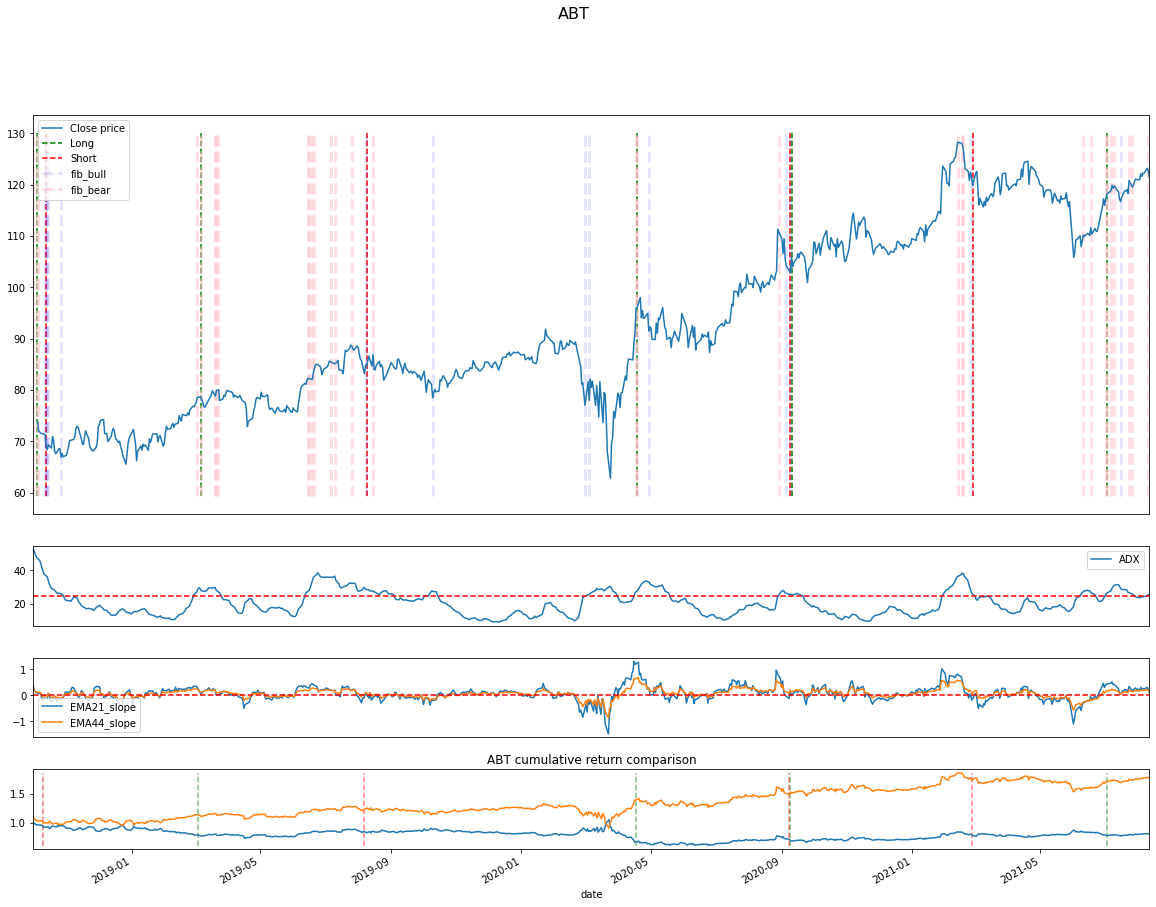

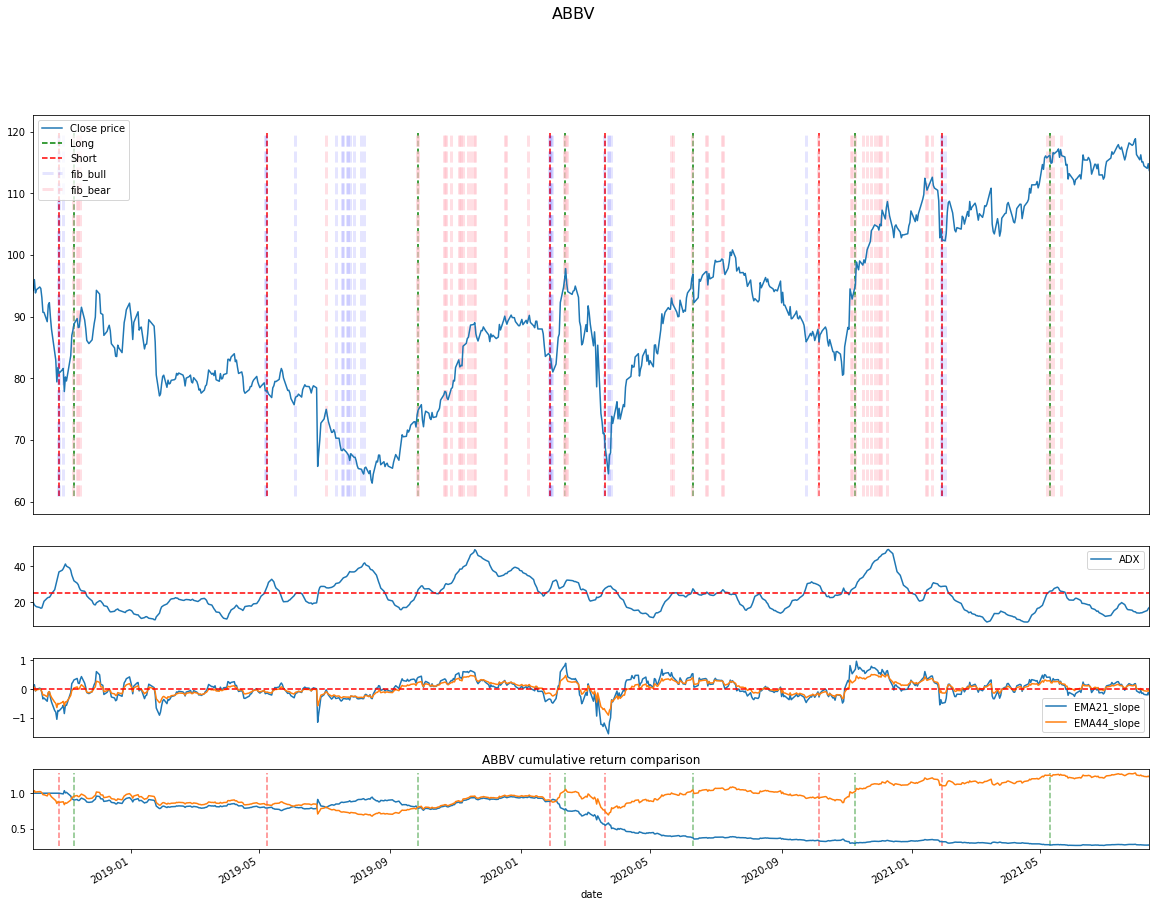

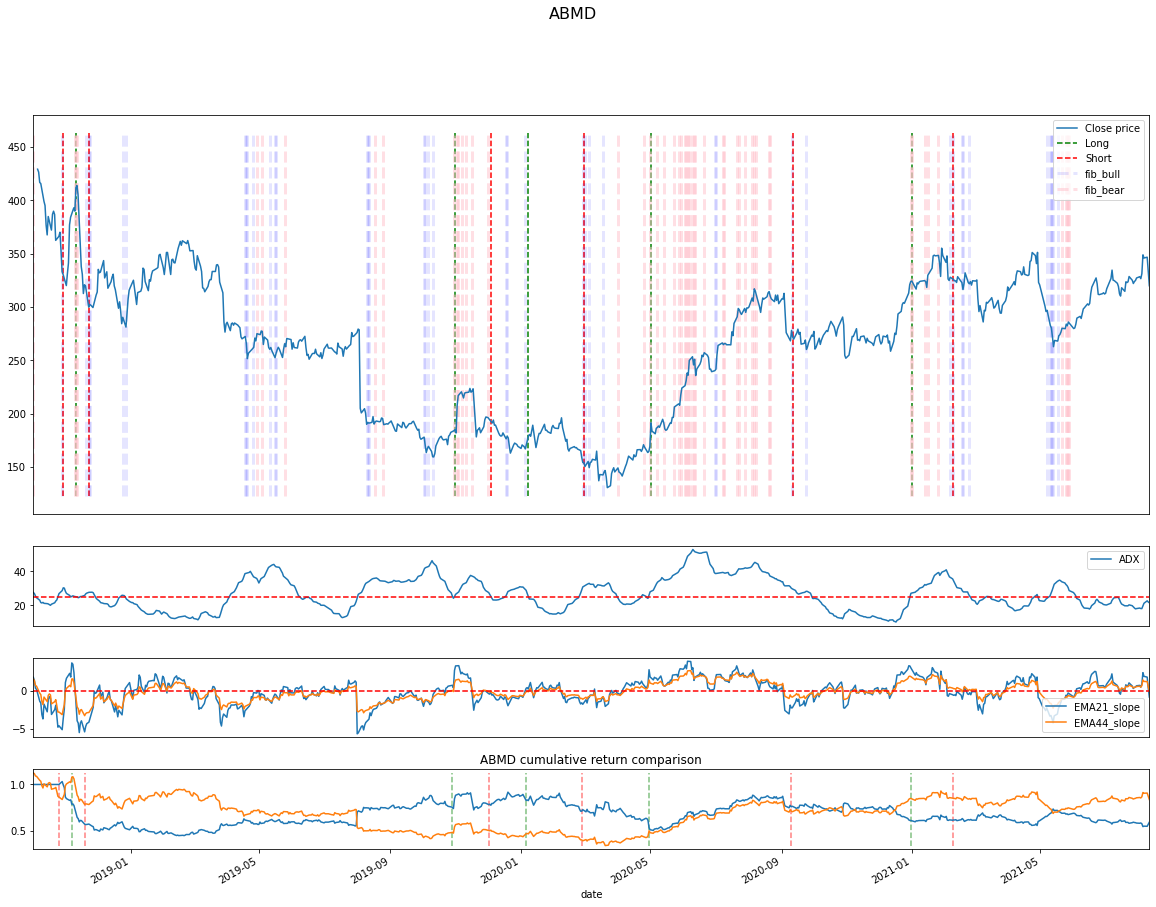

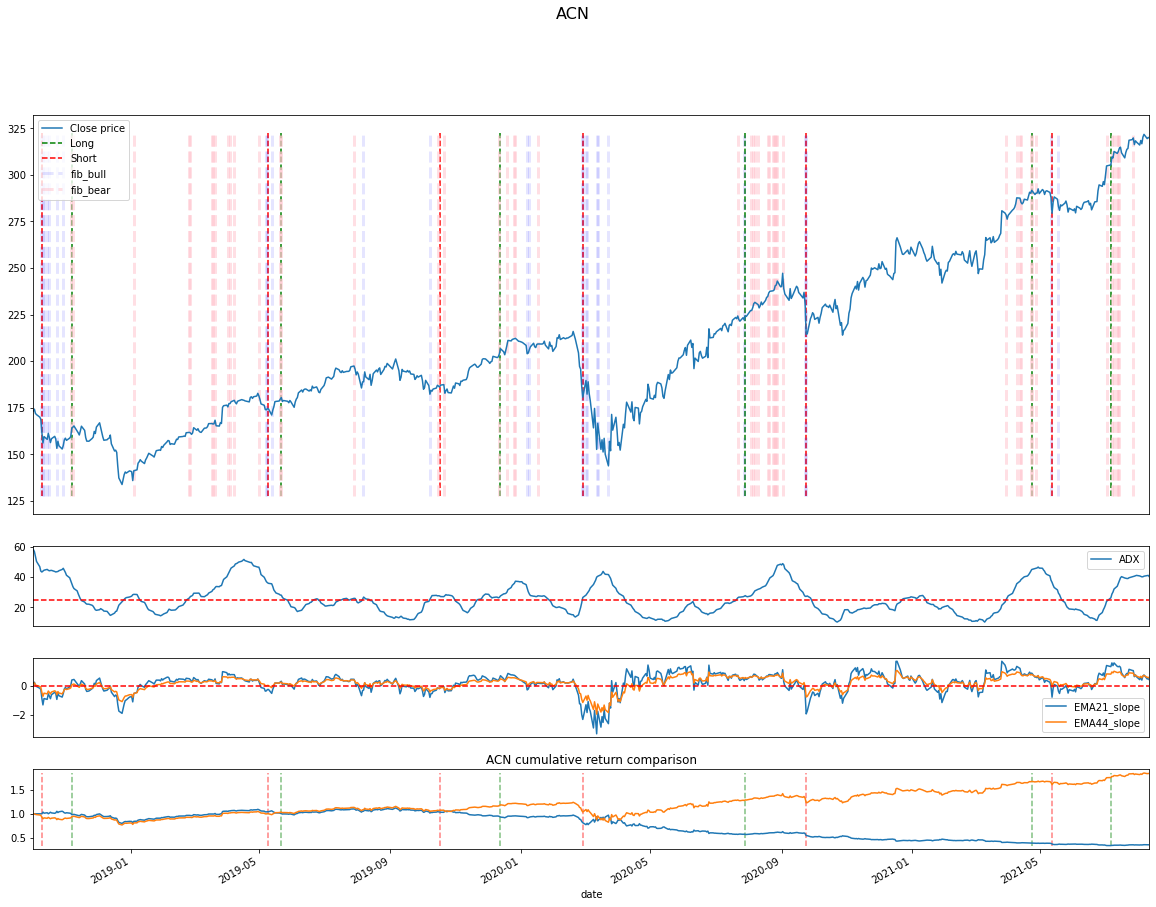

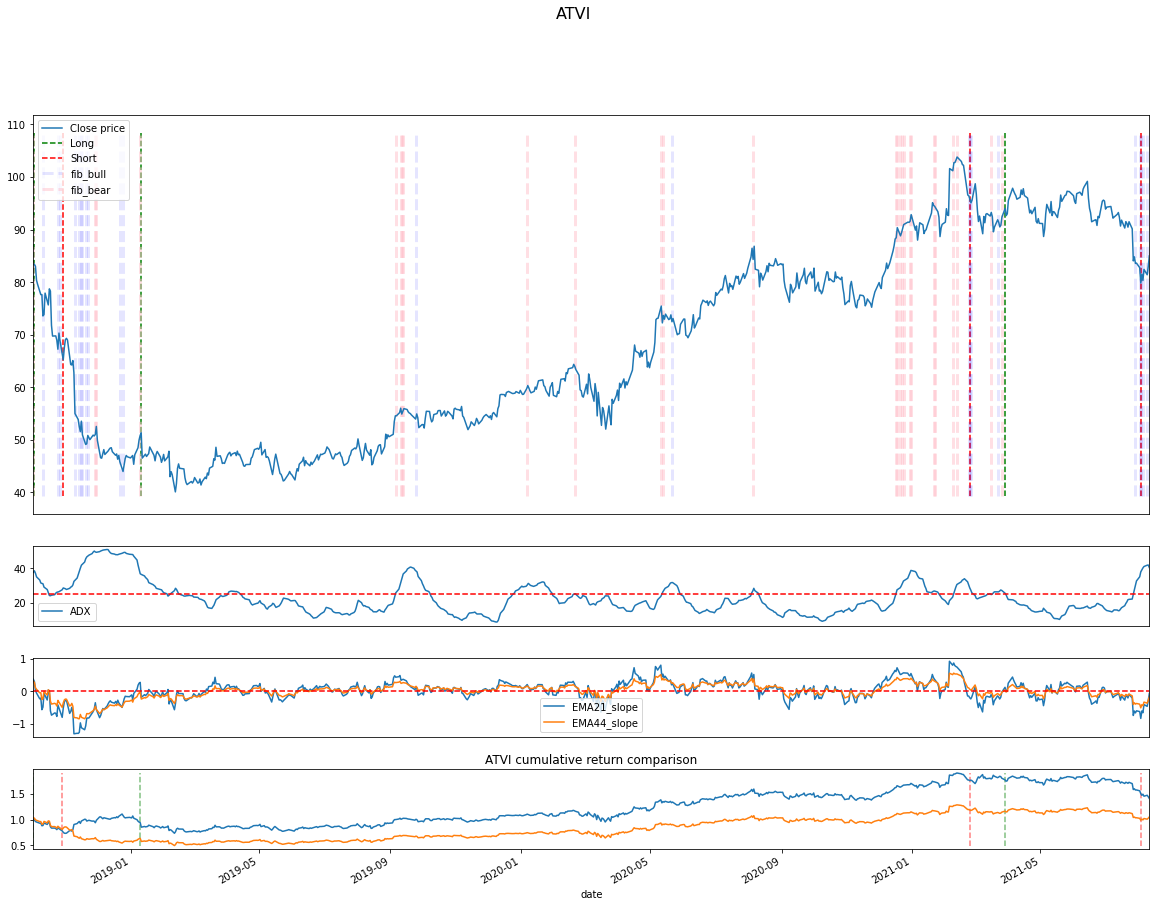

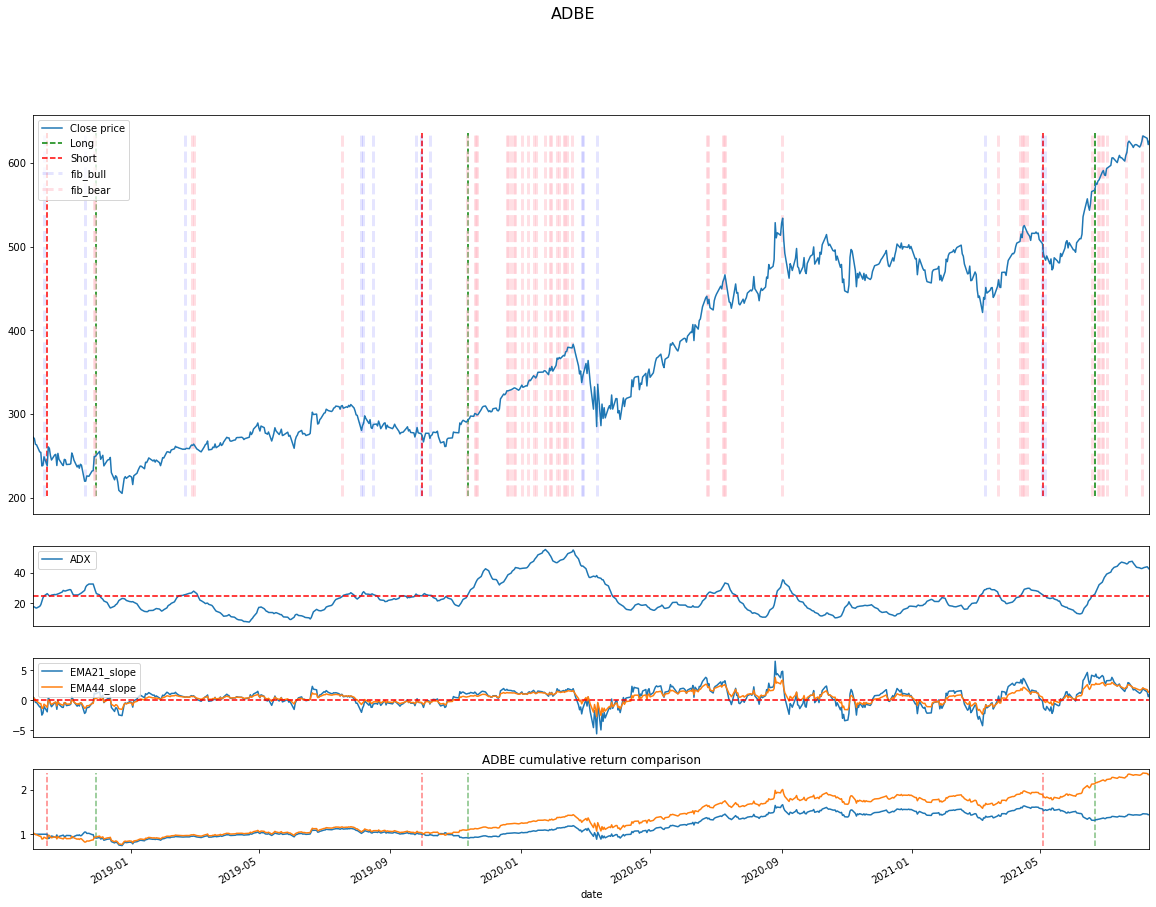

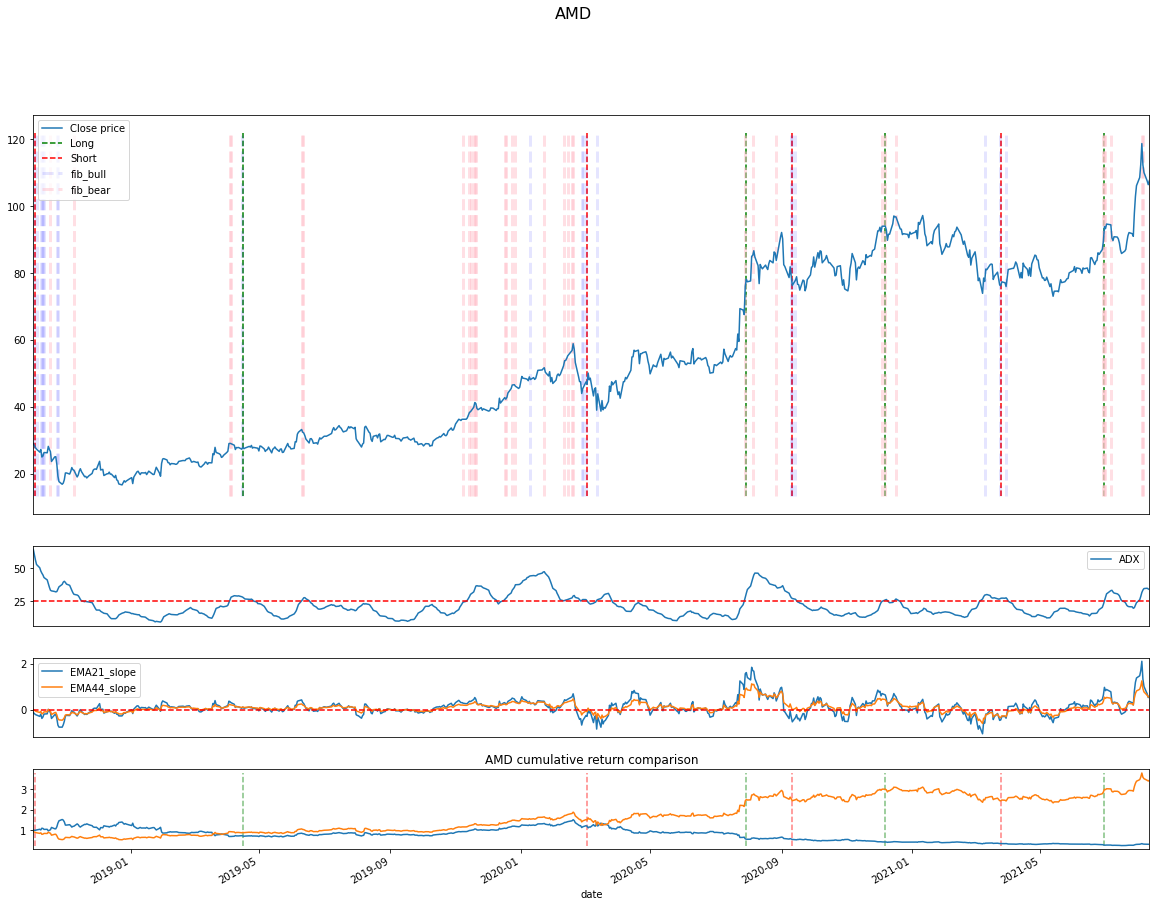

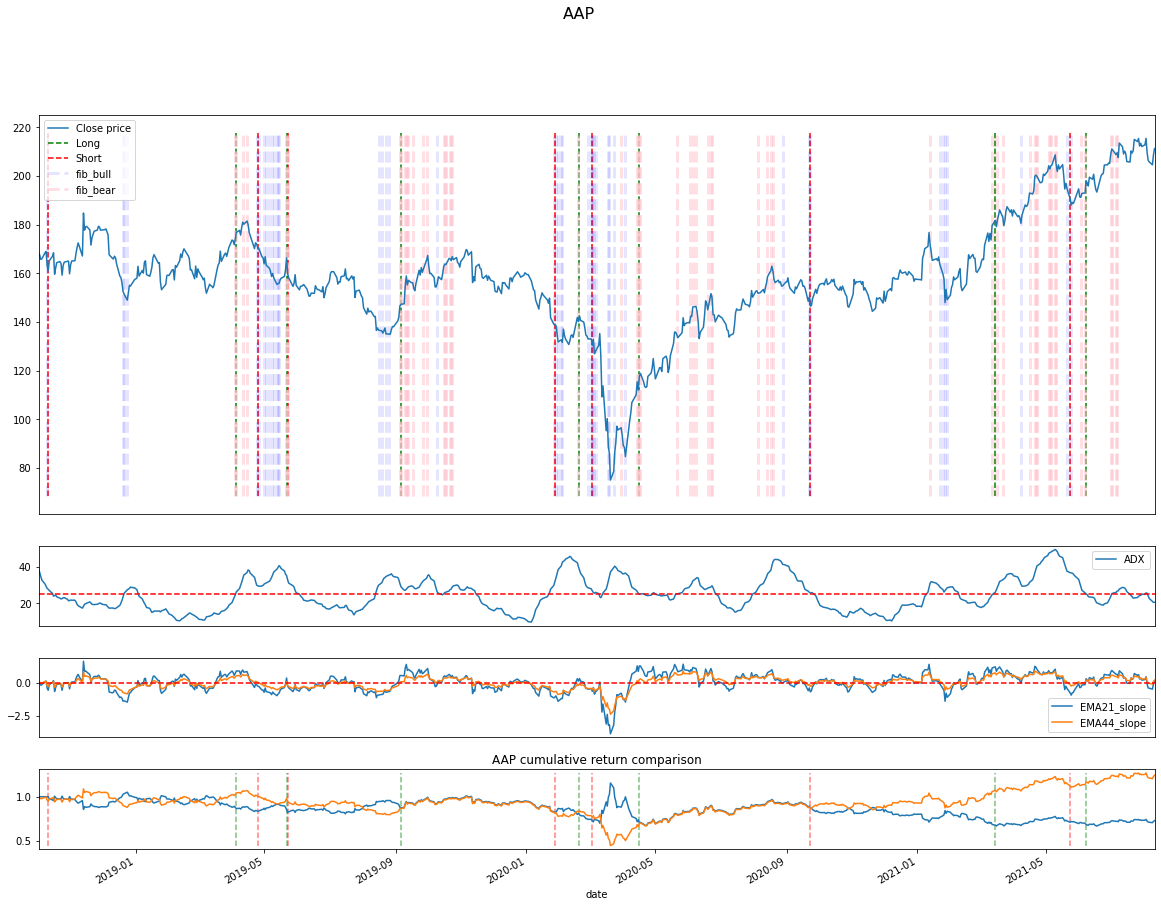

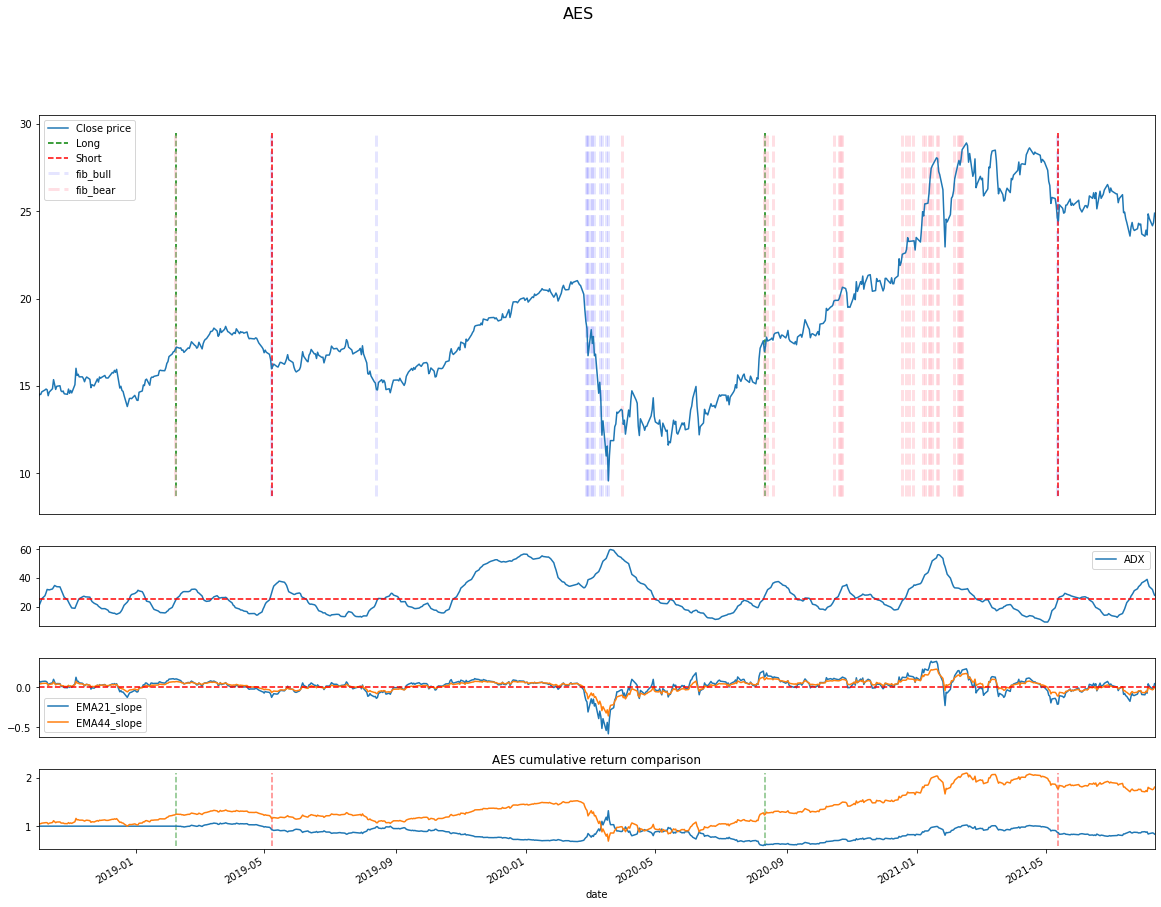

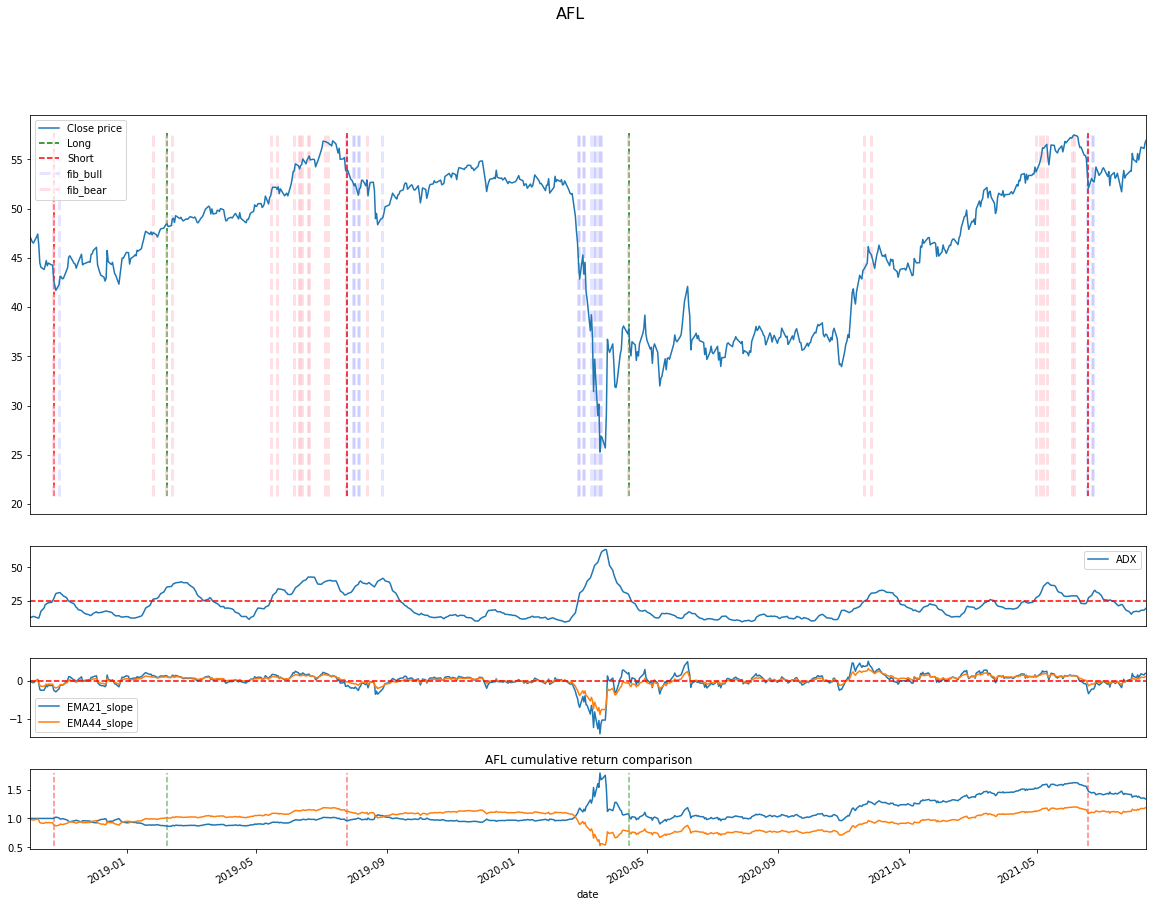

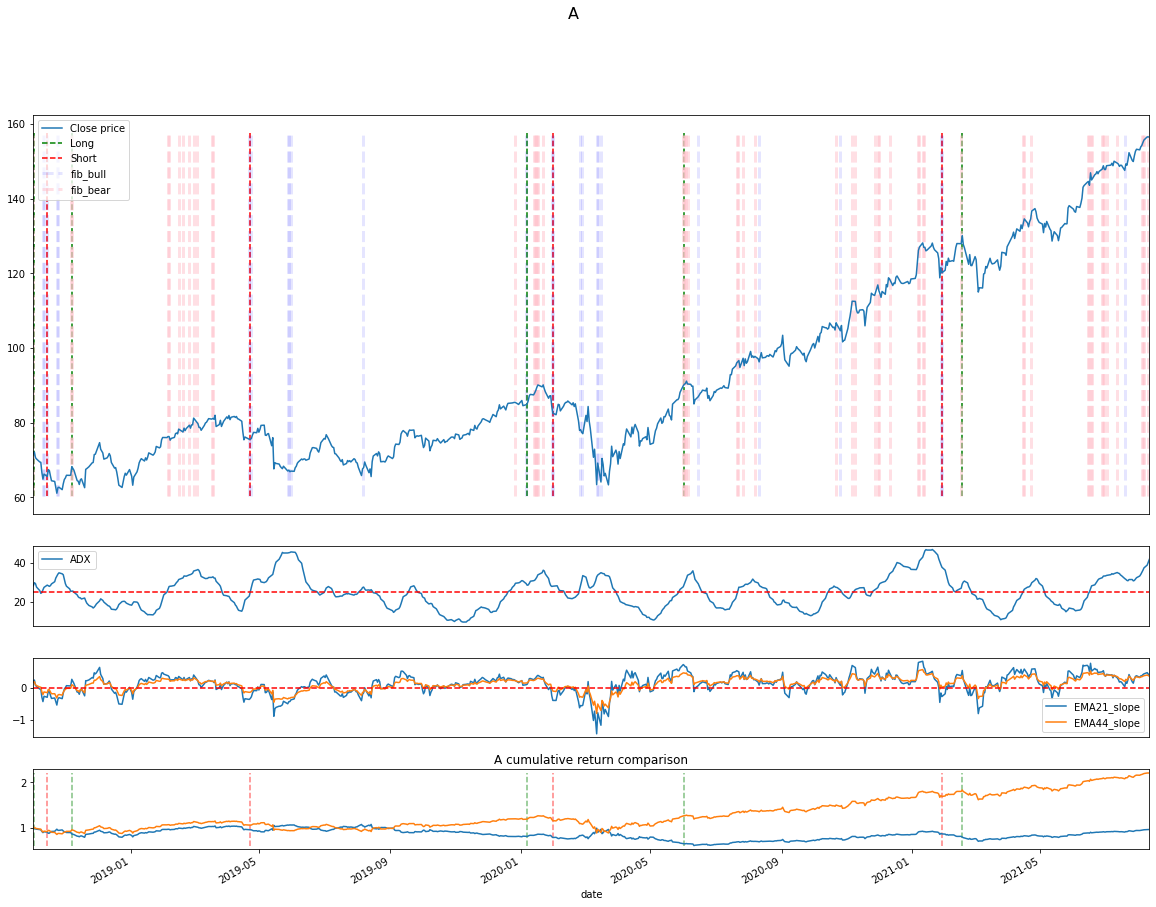

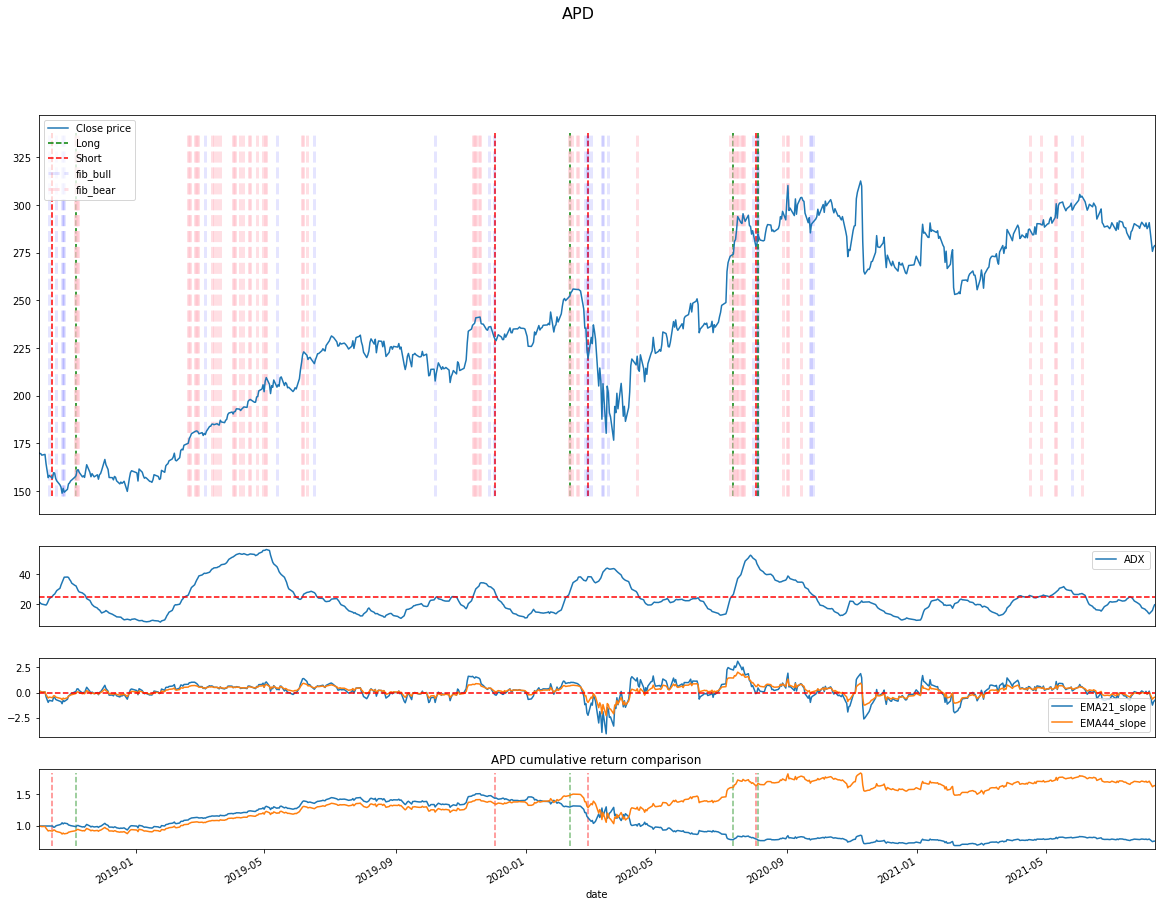

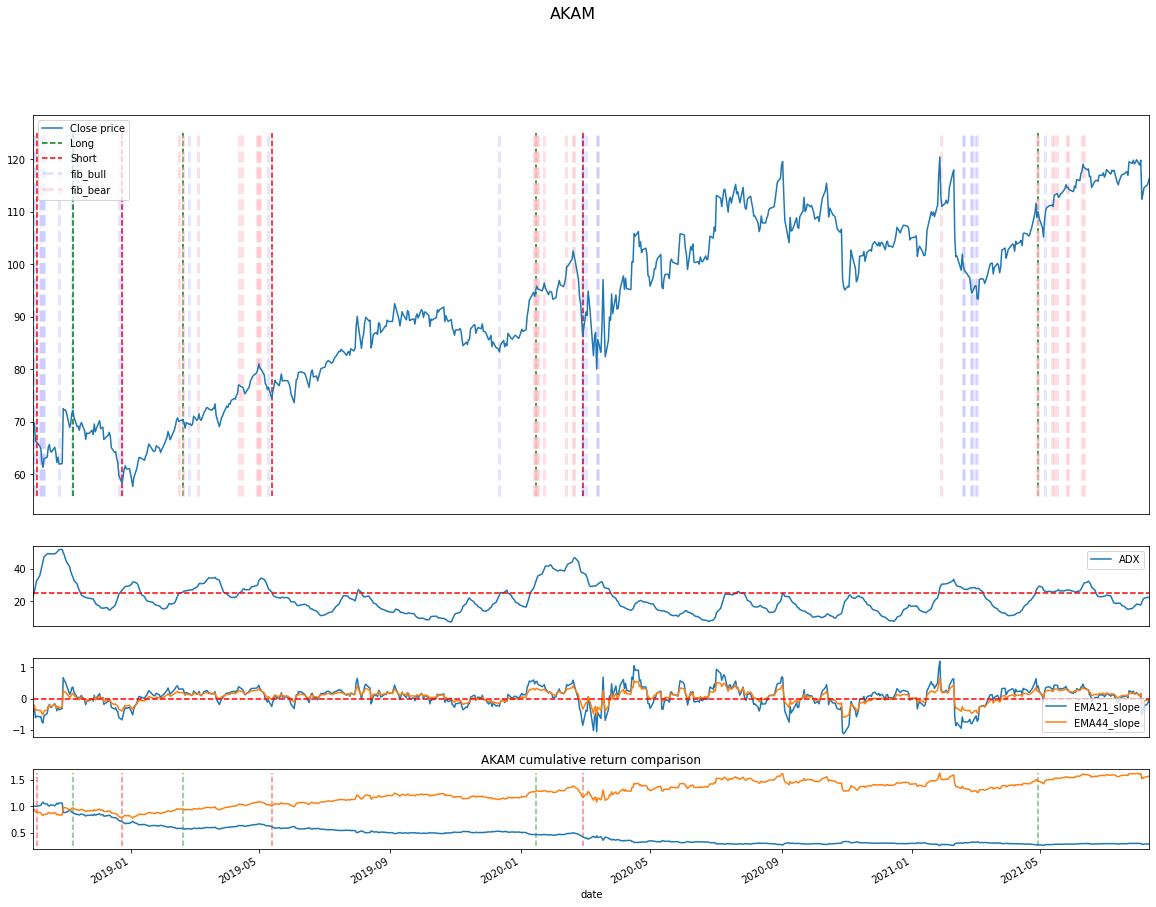

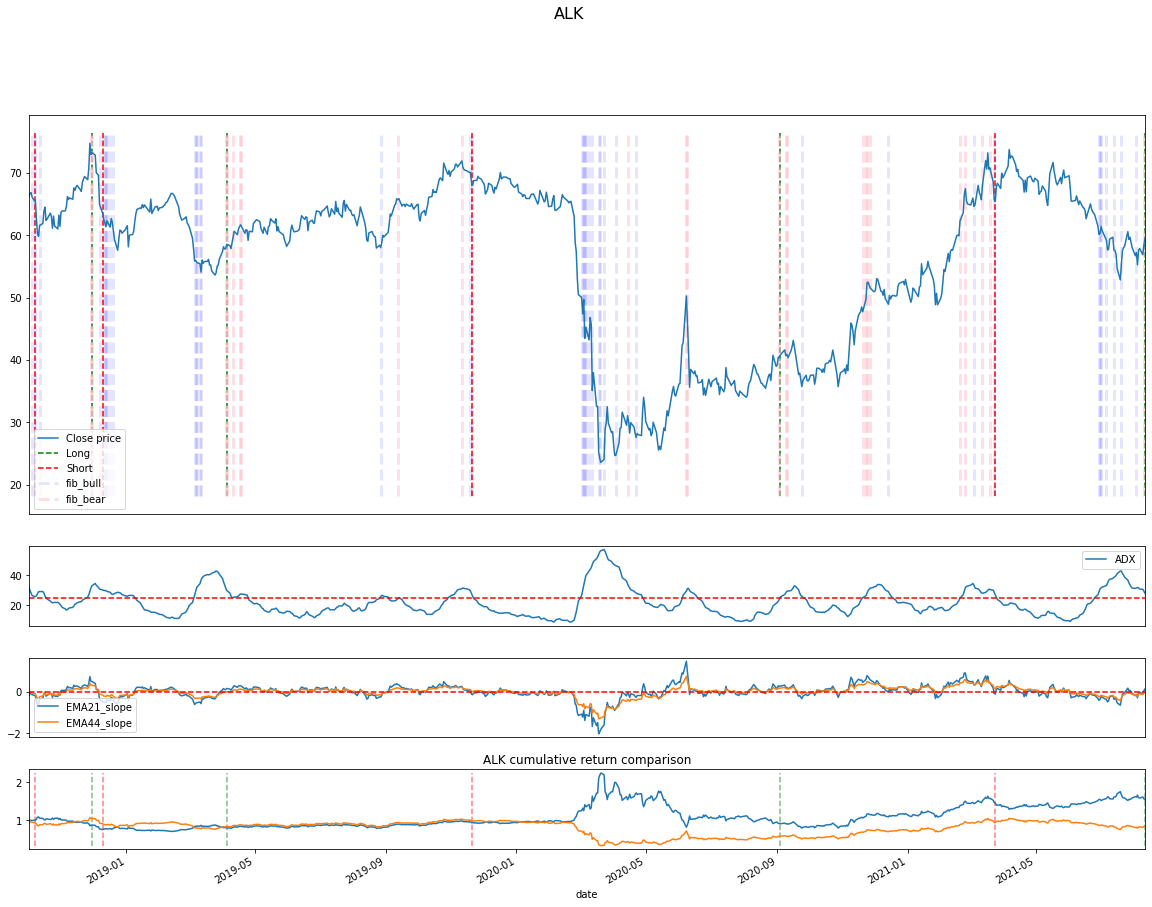

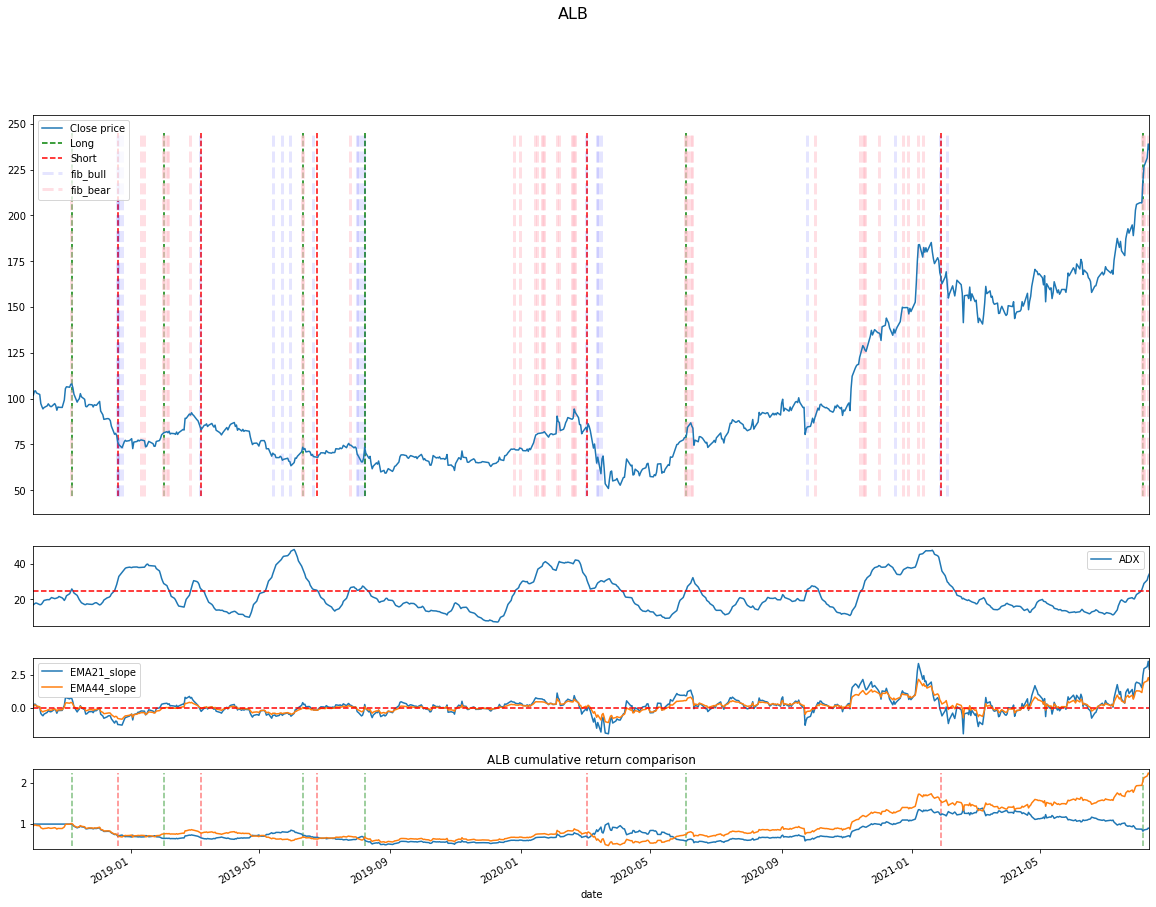

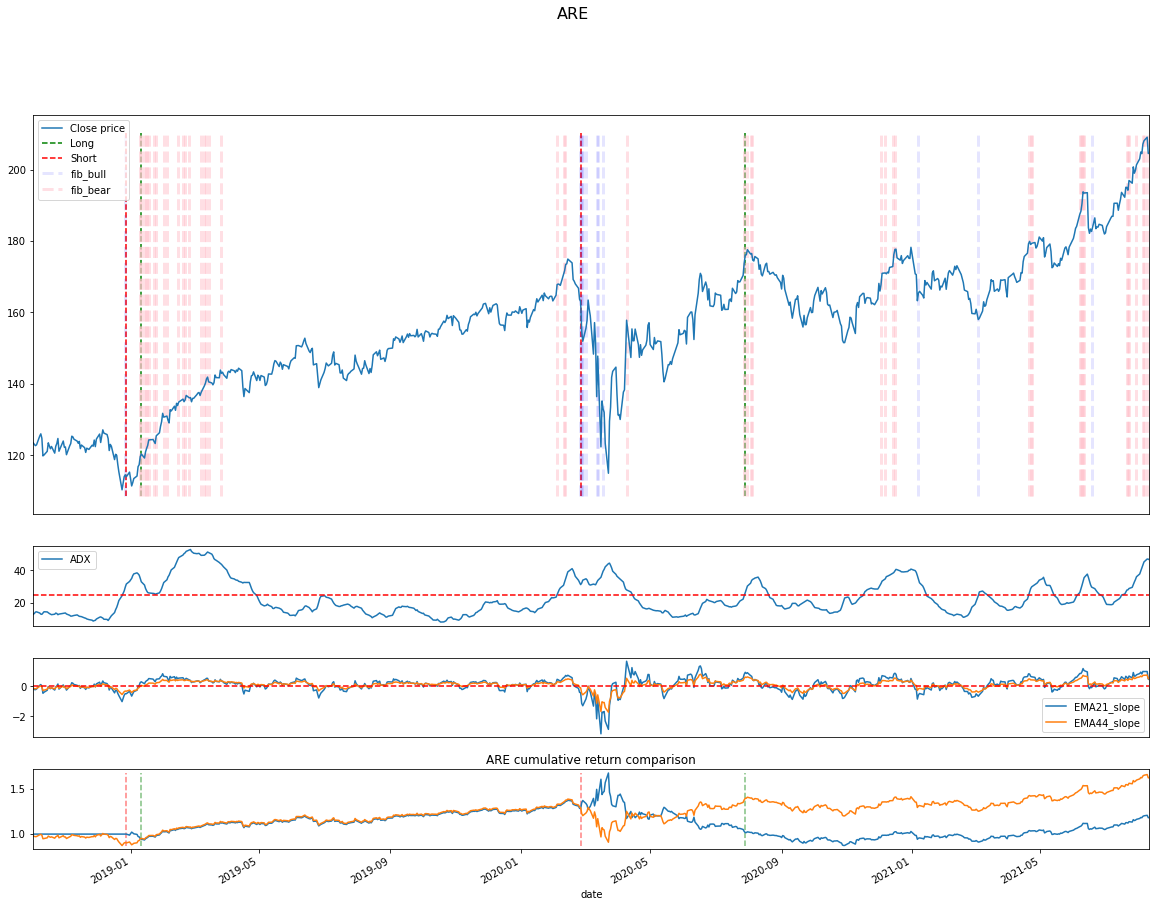

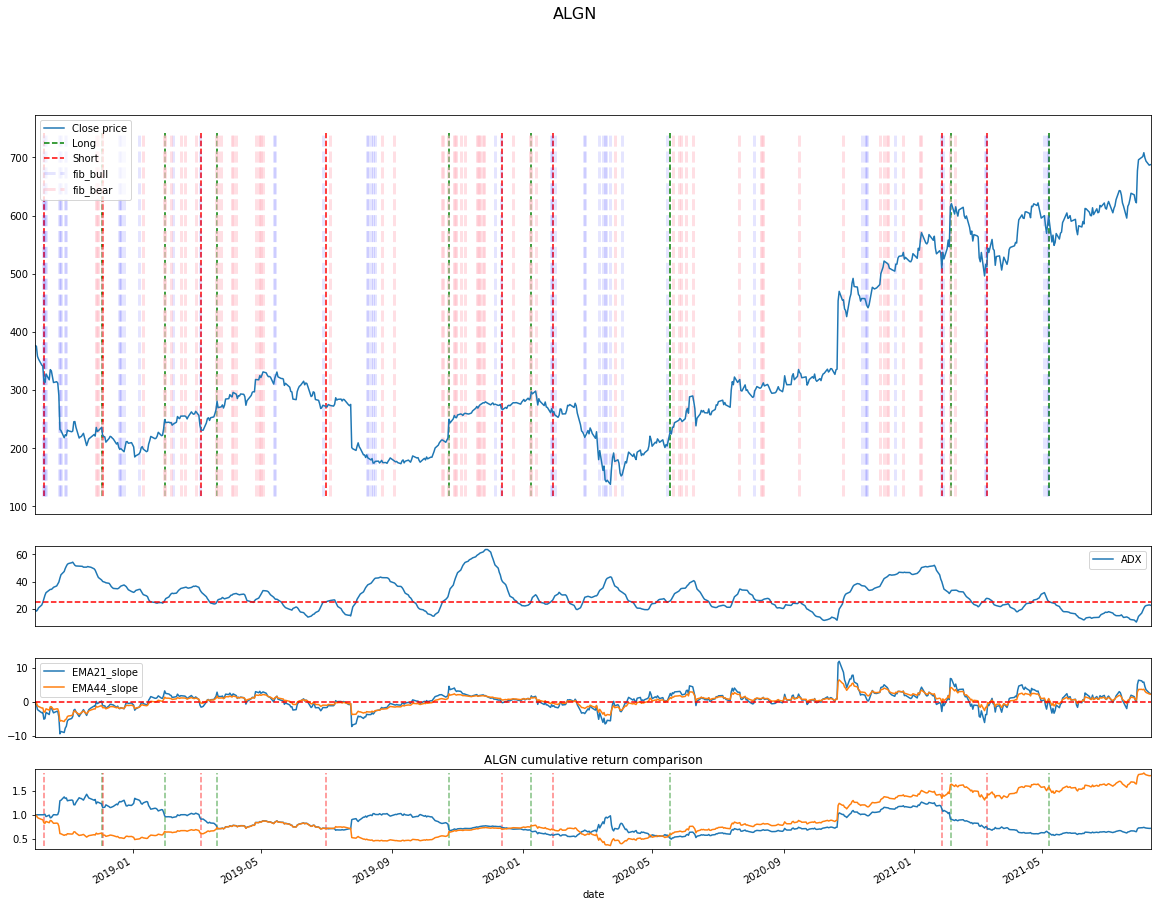

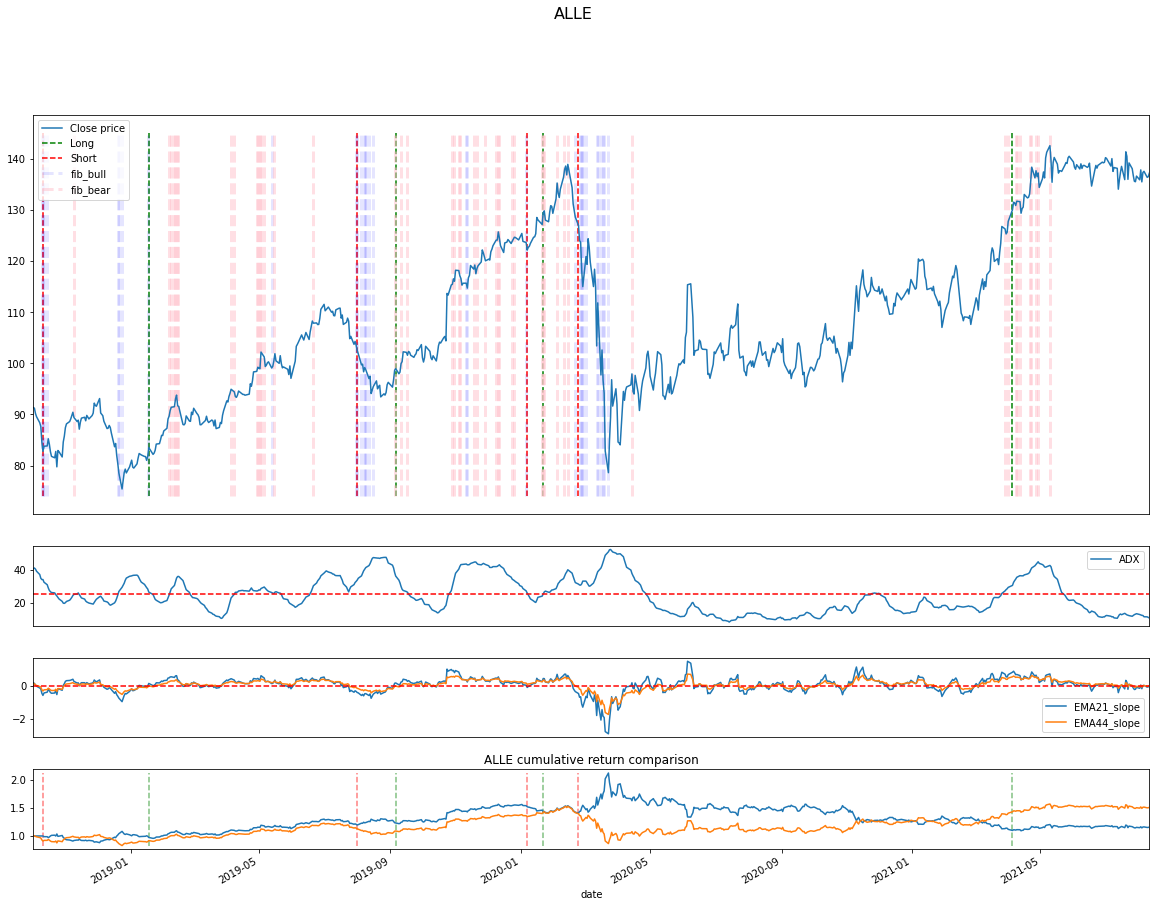

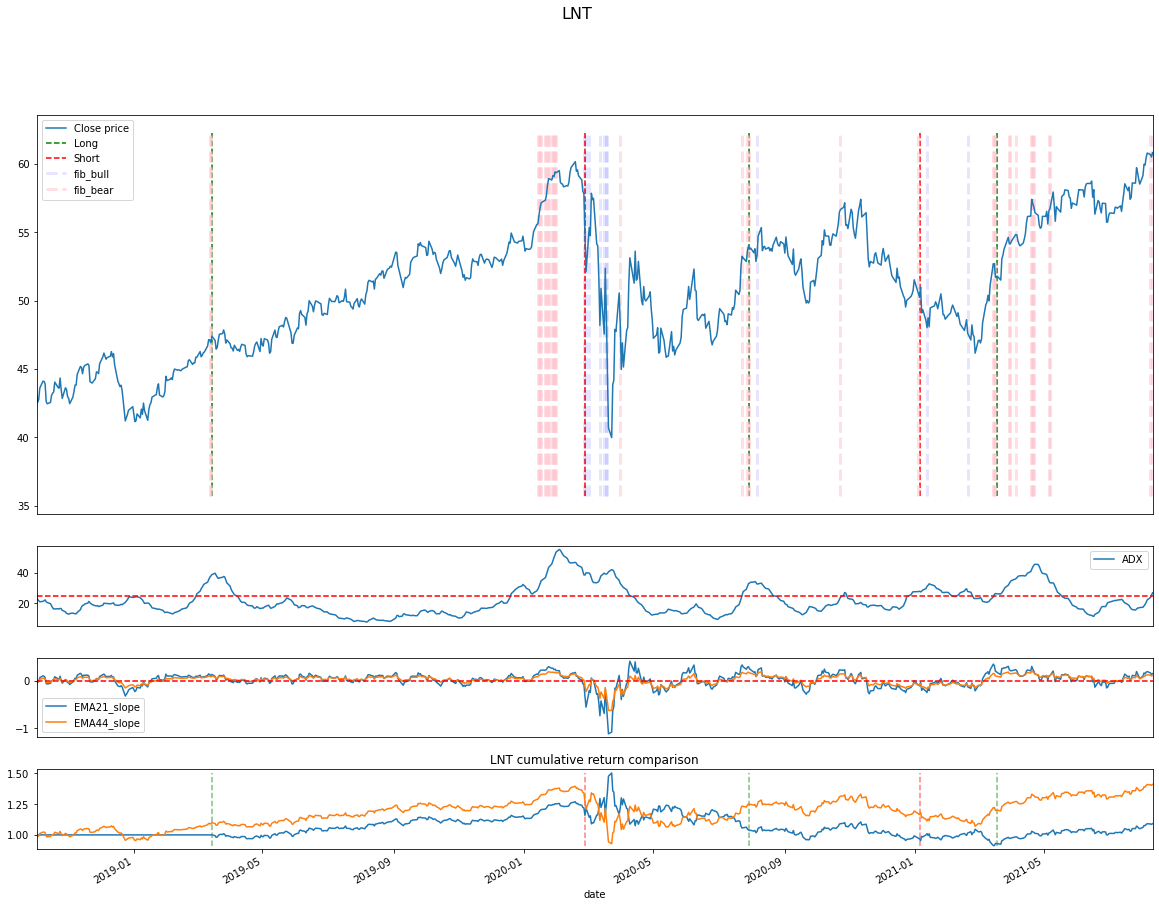

In [133]:
tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()
# tickers

for ticker in tickers[0:20]:
    fibo_bollin(ticker, '2016-07-28', '2021-07-28')

In [96]:
# print(short)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# print(stock[['close', 'EMA21_slope', 'EMA44_slope']])

In [10]:
# import mplfinance as fplt

# stock['date'] = pd.to_datetime(stock['date'], unit = 'D')
# fplt.plot(stock.set_index('date'), type = 'candle', title = f'{ticker} stock price', ylabel = 'price')